## Public Transportation Numbers in 44 Healthiest Cities

In [1]:
# Dependencies
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

# Import the API key
from api_keys import geoapify_key

In [2]:
# Create a function to get each of the city coordinates
def get_city_coordinates(city_name):
    # Set base url for geoapify_geocode
    geoapify_geocode_url = "https://api.geoapify.com/v1/geocode/search"

    # Set parameters dictionary
    params = {
        "text": city_name,
        "apiKey": geoapify_key,
        "limit": 1
    }

    # Run a request using the params dictionary
    city_response = requests.get(geoapify_geocode_url, params = params)

    # Check that the status code was successful
    if city_response.status_code == 200:

        # Convert response to JSON
        city_data = city_response.json()

        # Get the first feature
        features = city_data.get("features", [])
        if features:
            properties = features[0].get("properties", {})
            city_info = {
                "name": properties.get("city", city_name),
                "lon": properties.get("lon"),
                "lat": properties.get("lat")
            }
            return city_info
        else:
            print("Error 1")
    else:
        print("Error: ", city_response.status_code)        

In [3]:
# Create a function for the if/else statement to get number of public transportation
def num_of_public_transport(lat, lon, radius = 5000):
    
    # Set base url for geoapify_places
    geoapify_places_url = "https://api.geoapify.com/v2/places"

    # List the public transport categories we want to use
    transport_categories = [
        "public_transport.light_rail",
        "public_transport.monorail",
        "public_transport.subway",
        "public_transport.bus",
        "public_transport.tram"
    ]
    total_public_transport = 0

    # Start a for loop for each category
    for category in transport_categories:
        # Set parameters dictionary
        params = {
            "categories": category,
            "apiKey": geoapify_key,
            "filter": f"circle:{lon},{lat},{radius}",
            "limit": 150
        }
    
    
        # Run a request using the params dictionary
        public_transport_response = requests.get(geoapify_places_url, params = params)
        
        # Create an if/else statement for the amount of transportation if status code is 200
        if public_transport_response.status_code == 200:
            # Convert response to JSON
            public_transport_data = public_transport_response.json()
            public_transport = public_transport_data.get("features", [])
            count_public_transport = len(public_transport)
            total_public_transport += count_public_transport
        else:
            print(f"Error for {category}: {response.status_code}")
    return total_public_transport
        

In [4]:
# Read city names from the csv file
cities_df = pd.read_csv("healthy_lifestyle_city_2021.csv")
city_names = cities_df["City"]

# List to store the results
results = []

# Loop through each city
for city in city_names:
    city_info = get_city_coordinates(city)
    if city_info:
        lat = city_info["lat"]
        lon = city_info["lon"]
        total_transport = num_of_public_transport(lat, lon)
        results.append({
            "City": city_info["name"],
            "Latitude": lat, 
            "Longitude": lon,
            "Total Public Transport Count": total_transport
        })
    else:
        print(f"Error")
# Create a dataframe for the results
results_df = pd.DataFrame(results)

# Print the two columns I want to double check that my code is working
print(results_df[["City", "Total Public Transport Count"]])

                               City  Total Public Transport Count
0                         Amsterdam                           326
1                            Sydney                           184
2                            Vienna                           376
3                         Stockholm                           249
4                        Copenhagen                           193
5                          Helsinki                           310
6                           Fukuoka                           175
7                            Berlin                           408
8                         Barcelona                           295
9                         Vancouver                           152
10                        Melbourne                           125
11                          Beijing                           220
12                          Bangkok                           178
13  Autonomous City of Buenos Aires                           216
14        

In [5]:
# Filter the results DataFrame to the two columns I want
filtered_df = results_df[["City", "Total Public Transport Count"]]

# Save to a csv file
filtered_df.to_csv("public_transport_summary.csv", index = False)

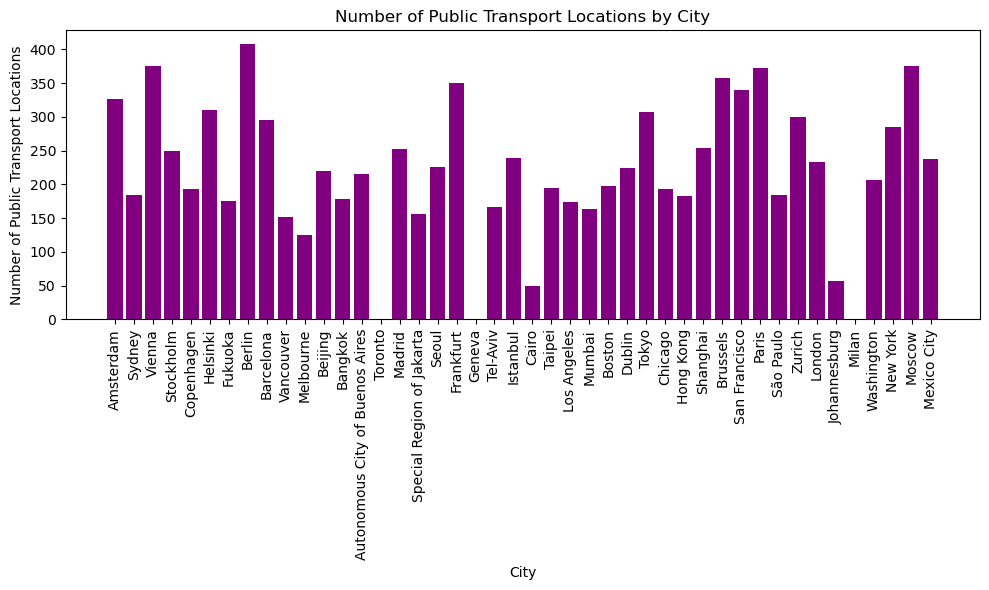

In [26]:
# Create a scatterplot of the amount of public transportation and population
plt.figure(figsize=(10,6))
plt.bar(results_df["City"], results_df["Total Public Transport Count"], color = "purple")
plt.xlabel("City")
plt.ylabel("Number of Public Transport Locations")
plt.title("Number of Public Transport Locations by City")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()


In [30]:
# Create a new column 'Training Preferences' based on 'Outdoor activities(City)'
def classify_training_preferences(row):
    # Extract values
    outdoor_activities = row['Outdoor activities(City)']
    # Define thresholds for classification based on outdoor activities
    if outdoor_activities > cities_df['Outdoor activities(City)'].median():
        return 'Outdoor/marathon'
    elif outdoor_activities < cities_df['Outdoor activities(City)'].median() / 2:
        return 'Home workouts'
    else:
        return 'Gym workouts'

In [33]:
# Apply the classify_training_preferences to create a new column
cities_df["Training Preferences"] = cities_df.apply(classify_training_preferences, axis = 1)
print(cities_df)

                City  Rank Sunshine hours(City)  \
0          Amsterdam     1                 1858   
1             Sydney     2                 2636   
2             Vienna     3                 1884   
3          Stockholm     4                 1821   
4         Copenhagen     5                 1630   
5           Helsinki     6                 1662   
6            Fukuoka     7                 2769   
7             Berlin     8                 1626   
8          Barcelona     9                 2591   
9          Vancouver    10                 1938   
10         Melbourne    11                 2363   
11           Beijing    12                 2671   
12           Bangkok    13                 2624   
13      Buenos Aires    14                 2525   
14           Toronto    15                 2066   
15            Madrid    16                 2769   
16           Jakarta    17                 2983   
17             Seoul    18                 2066   
18         Frankfurt    19     

In [35]:
combined_df = pd.merge(filtered_df, cities_df, on = "City")
print(combined_df)

             City  Total Public Transport Count  Rank Sunshine hours(City)  \
0       Amsterdam                           326     1                 1858   
1          Sydney                           184     2                 2636   
2          Vienna                           376     3                 1884   
3       Stockholm                           249     4                 1821   
4      Copenhagen                           193     5                 1630   
5        Helsinki                           310     6                 1662   
6         Fukuoka                           175     7                 2769   
7          Berlin                           408     8                 1626   
8       Barcelona                           295     9                 2591   
9       Vancouver                           152    10                 1938   
10      Melbourne                           125    11                 2363   
11        Beijing                           220    12           

In [43]:
grouped_data = combined_df.groupby("Training Preferences")["Total Public Transport Count"].sum().reset_index()
print(grouped_data)

  Training Preferences  Total Public Transport Count
0         Gym workouts                          2383
1        Home workouts                          1382
2     Outdoor/marathon                          4992


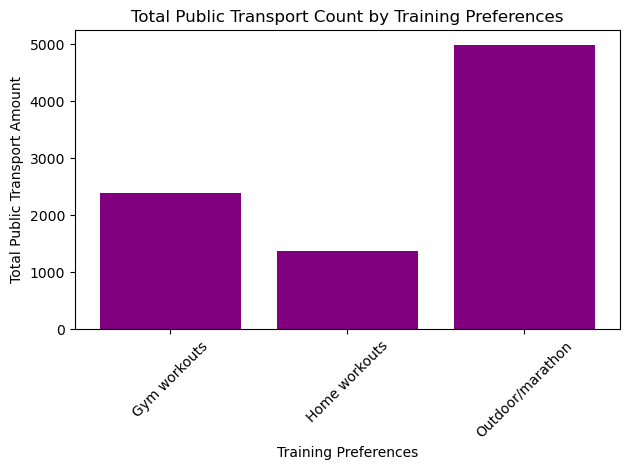

In [46]:
plt.bar(grouped_data["Training Preferences"], grouped_data["Total Public Transport Count"], color = "purple")
plt.title("Total Public Transport Count by Training Preferences")
plt.xlabel("Training Preferences")
plt.ylabel("Total Public Transport Amount")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

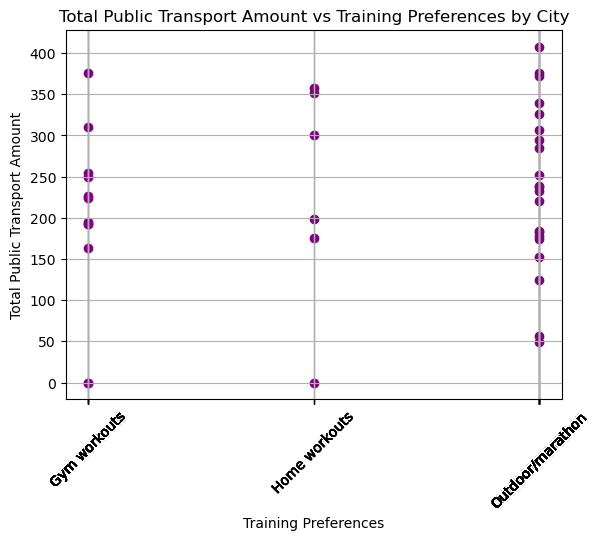

In [51]:
combined_df["Training Preferences Code"] = pd.Categorical(combined_df["Training Preferences"]).codes
plt.scatter(combined_df["Training Preferences Code"], combined_df["Total Public Transport Count"], color = "purple")
plt.title("Total Public Transport Amount vs Training Preferences by City")
plt.xlabel("Training Preferences")
plt.ylabel("Total Public Transport Amount")
plt.xticks(ticks = combined_df["Training Preferences Code"], labels = combined_df["Training Preferences"], rotation = 45)
plt.grid()
plt.show()
                                    